# Model Selection for Large Scale Learning

**Gabriele Degola**

Grenoble INP - Ensimag, MoSIG DSAI

---

<h2>Sample Selection for Fair and Robust Training<h2>



## Introduction

The objective of this report is the analysis of a research paper published in 2021 in a machine learning conference, in order to illustrate the method as implemented by the author, together with model selection or model assessment.

The chosen paper is [Sample Selection for Fair and Robust Training](https://openreview.net/forum?id=IZNR0RDtGp3), by Y. Roh *et al*.. The paper deals with a non-traditional view of a classification problem: fair and robust training of classification model. Usually, the goal is to train a model to obtain the highest accuracy as possible, defined as the fraction of correctly classified examples. However, objectives such as fairness and robustness are becoming more and more important in modern machine learning applications, but are not taken into account by traditional classification algorithm. From the paper, "fairness is about learning an unbiased model, while robustness is about learning from corrupted data, and it is known that addressing only one of them may have an adverse affect on the other". The authors address the problem proposing a method for unbiased selection of training examples in the presence of data corruption, with the aim of simultaneously improving both fairness and robustness. 

The code provided by the authors is implemented in PyTorch, a popular Python library tipically used for deep learning, which allows to train models on GPUs. Here, it is used to train a linear classifier (logistic regression), exploiting the powerful methods for data sampling provided by PyTorch.

I therefore use here a modified version of the authors' code, which is delivered together with this report. In particular, as the proposed method is not dependent from the chosen model, Support Vector Machines is included and tested additionally to logistic regression. A detailed description of the performed experiments follows, together with a description and analysis of the method.

Authors' code is available in this GitHub [repository](https://github.com/yuji-roh/fair-robust-selection), while useful supplementary material is available [here](https://openreview.net/attachment?id=IZNR0RDtGp3&name=supplementary_material).

### Notation

In the following sections and in the code, this notation is used:

- **x** denotes the independent variables, used to train the model and make predictions;
- **y** denotes the dependent variable, such as whether a convict is a recidivist or not;
- **z** denotes a sensitive variable which is used to analyse fairness, for example the sex or race of the convicted.

In most real datasets and in the following experiments **y** and **z** are taken as binary variables.

### Fairness measures

Several metrics have been proposed in the literature for measuring fairness in a classifier. The paper focuses on *Equalized Odds* and *Demographic Parity* disparities. A model is perfectly fair when the considered disparity is zero.

#### Equalized Odds

The goal of Equalized Odds (EO) is obtaining the same accuracy between different sensitive groups, conditioned on the true labels. It is defined as:

$$\text{EO disparity} = \max_{z\in \mathbb{Z},y\in\mathbb{Y}} |P(\hat{\mathbf{y}}=1|\mathbf{z}=z,\mathbf{y}=y)-P(\mathbf{\hat{y}}=1|\mathbf{y}=y)|$$

#### Demographic Parity

The goal of Demographic Parity (DP) is instead to obtain the same positive prediction rate for different sensitive groups. It is defined as:

$$ \text{DP disparity} = \max_{z\in \mathbb{Z}} |P(\hat{\mathbf{y}}=1|\mathbf{z}=z)-P(\mathbf{\hat{y}}=1)|$$

For simplicity, only Equalized Odds is used in the performed experiments.

### Noise injection

The proposed method does not only deal with algorithmic fairness, but also with robustness. In the performed experiments, this is assessed trying to artificially reduce the model accuracy through label flipping: a random portion of data labels are modified, turning them to 0 if the real label is 1 or viceversa. An algorithm is robust if performs well on real labels, even though it was trained on corrupted labels. 10% of training labels are flipped for the experiments.

### Importing libraries

In [ ]:
import random
import warnings
import copy
from argparse import Namespace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from FairRobustSampler import FairRobust, CustomDataset
from models import weights_init_normal, lr_epoch, svm_epoch, test_model, plot_boundaries
from utils import corrupt_labels

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline

## Synthetic datasets

A first objective is to replicate the results reported by the author, in order to check their consistency and build a base for next experiments. The following code is built on a [Python notebook](https://github.com/yuji-roh/fair-robust-selection/blob/main/FairRobust_synthetic_label_flipping.ipynb) provided by the authors. At first, the same synthetic dataset used by the authors is tested. It consists of two explanatory variables and a binary sensitive attribute, together with a binary target variable.

It is not easy to generate new synthetic data with a sensitive variable: it cannot be chosen randomly, but must be linked to the explanatory variables without being too similar to the target. The dataset generated by the authors consists of 3200 examples, where each observation $(x_1, x_2, y)$ is drawn from the following gaussian distributions:

$$(x_1, x_2)|y=1 \sim \mathcal{N}\left(\begin{pmatrix}1\\1\end{pmatrix}, \begin{pmatrix}5 & 1\\1 & 5\end{pmatrix}\right)$$

$$(x_1, x_2)|y=0 \sim \mathcal{N}\left(\begin{pmatrix}-1\\-1\end{pmatrix}, \begin{pmatrix}10 & 1\\1 & 3\end{pmatrix}\right)$$

while the sensitive variable $z$ is generated from a biased distribution:

$$P(z=1)=\frac{7P((x_1', x_2')|y=1)}{7P((x_1', x_2')|y=1)+P((x_1', x_2')|y=0)} $$

In the previous expression, $x_1'$ and $x_2'$ are the rotated $x_1$ and $x_2$:

$$(x_1', x_2') = (x_1\cos(\pi/5) - x_2\sin(\pi/5), x_1\sin(\pi/5) + x_2\cos(\pi/5))$$

According to a [related paper](https://arxiv.org/abs/1507.05259), the rotation angle (here $\pi/5$) controls the correlation between the sensitive attribute and the class label.

----

2000 examples are available for training, 200 for validation and 1000 for testing.

However, one of the first things that pops up when looking at the implementation is that no validation is performed by the authors. They just consider the model as it is trained after 400 training epochs and apply it to the test data. We know that this may introduce some problems, as the model is likely to overfit and not obtain the best possible performances on the test data. For example, the best performing model can be reached at epoch 300, while at epoch 400 it obtains better accuracy on training data but not on test.

The 200 validation examples are generated by the authors but not used. They are therefore imported and used for the analysis. These examples are corrupted as the training examples, as they should follow the training distribution. Instead, test examples are not modified, as they must follow the original distribution for evaluating robustness.

In [ ]:
n_features = 3    # number of input features, including sensitive variable
poi_ratio = 0.1   # percentage of perturbated labels
seed = 42         # random seed for replicability
random.seed(seed)
np.random.seed(seed)

xz_train = np.load('./synthetic_data/xz_train.npy')
y_train = np.load('./synthetic_data/y_noise_general.npy')   # perturbated training labels, provided by authors
z_train = np.load('./synthetic_data/z_train.npy')

xz_val = np.load('./synthetic_data/xz_val.npy')
y_val = np.load('./synthetic_data/y_val.npy')
z_val = np.load('./synthetic_data/z_val.npy')
y_val = corrupt_labels(y_val, poi_ratio=poi_ratio)

xz_test = np.load('./synthetic_data/xz_test.npy')
y_test = np.load('./synthetic_data/y_test.npy')
z_test = np.load('./synthetic_data/z_test.npy')

xz_train = torch.FloatTensor(xz_train)
y_train = torch.FloatTensor(y_train)
z_train = torch.FloatTensor(z_train)

xz_val = torch.FloatTensor(xz_val)
y_val = torch.FloatTensor(y_val)
z_val = torch.FloatTensor(z_val)

xz_test = torch.FloatTensor(xz_test)
y_test = torch.FloatTensor(y_test)
z_test = torch.FloatTensor(z_test)

if torch.cuda.is_available():
    xz_train = xz_train.cuda()
    y_train = y_train.cuda()
    z_train = z_train.cuda()
    
    xz_val = xz_val.cuda()
    y_val = y_val.cuda()
    z_val = z_val.cuda()

    xz_test = xz_test.cuda()
    y_test = y_test.cuda()
    z_test = z_test.cuda()

In [ ]:
print("---------- Number of Data ----------" )
print(
    "Train data : %d, Val data: %d, Test data : %d "
    % (len(y_train), len(y_val), len(y_test))
)       
print("------------------------------------")

---------- Number of Data ----------
Train data : 2000, Val data: 200, Test data : 1000 
------------------------------------


At first, the method hyperparameters are kept as used by the authors. For time constraints, training procedure is run once.

In [ ]:
n_epochs = 400    # number of training epochs
alpha = 0.001     # step size for updating sampler's lambda
batch_size = 100  # batch size for data loading
val_epoch = 10    # number of epochs between validation steps

In [ ]:
parameters = Namespace(warm_start=100, tau=1 - poi_ratio, alpha=alpha, batch_size=batch_size)
train_data = CustomDataset(xz_train, y_train, z_train)

### Logistic regression

#### Vanilla logistic regression

Logistic regression is a simple yet powerful linear model for classification, used by the authors to evaluate the effectiveness of their method. It is useful to first run the *vanilla* logistic regression classifier, without any specific sample selection, in order to verify improvements in fairness and robustness when the proposed sampler will be used.

Here, the best trained model is selected through *hold-out*: every 10 training epochs, the model is tested on the 200 validation examples and the model which attains the lowest error rate is then evaluated on the test set. The validation set is way smaller than the training set (proportion 1:10), so the results may be not extremely reliable. Let's anyway check how the model performs.

In [ ]:
# logistic regression is composed of a single linear layer
model = nn.Linear(n_features, 1)
if torch.cuda.is_available():
    model.cuda()
if seed is not None:
    torch.manual_seed(seed)
model.apply(weights_init_normal)

# optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999))
train_loader = DataLoader(train_data, num_workers=0)

train_losses = []
val_losses = []
best_loss = float('inf')

for epoch in range(n_epochs):
    print(epoch, end="\r")

    model.train()

    tmp_loss = []

    # model is trained here
    for data, target, _ in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        loss = lr_epoch(model, data, target, optimizer)
        tmp_loss.append(loss)

    # store training loss
    train_loss = sum(tmp_loss) / len(tmp_loss)
    train_losses.append(train_loss)
    
    model.eval()
    
    with torch.no_grad():
        if (epoch + 1) % val_epoch == 0:
            # validation step
            label_predicted = model.forward(xz_val)
            val_loss = nn.BCELoss()((F.tanh(label_predicted.squeeze()) + 1) / 2, (y_val.squeeze() + 1) / 2)
            val_loss = val_loss.item()
            if val_loss < best_loss:
                # save model with lowest error on validation set
                best_loss = val_loss
                best_epoch = epoch
                lr_simple_model = copy.deepcopy(model)
            # store validation loss
            val_losses.append(val_loss)
    
    # print intermediate results
    if (epoch + 1) % 50 == 0:
        print(f"epoch {epoch + 1}:\ttraining loss {train_loss:.3f}, validation loss {val_loss:.3f}")

epoch 50:	training loss 0.692, validation loss 0.672
epoch 100:	training loss 0.692, validation loss 0.672
epoch 150:	training loss 0.692, validation loss 0.672
epoch 200:	training loss 0.692, validation loss 0.672
epoch 250:	training loss 0.692, validation loss 0.672
epoch 300:	training loss 0.692, validation loss 0.672
epoch 350:	training loss 0.692, validation loss 0.672
epoch 400:	training loss 0.692, validation loss 0.672


After training, it is possible to visualize the learning curves. In addition, having two explanatory variables (plus the sensitive one) is handy for visualization of the resulting decision boundary.

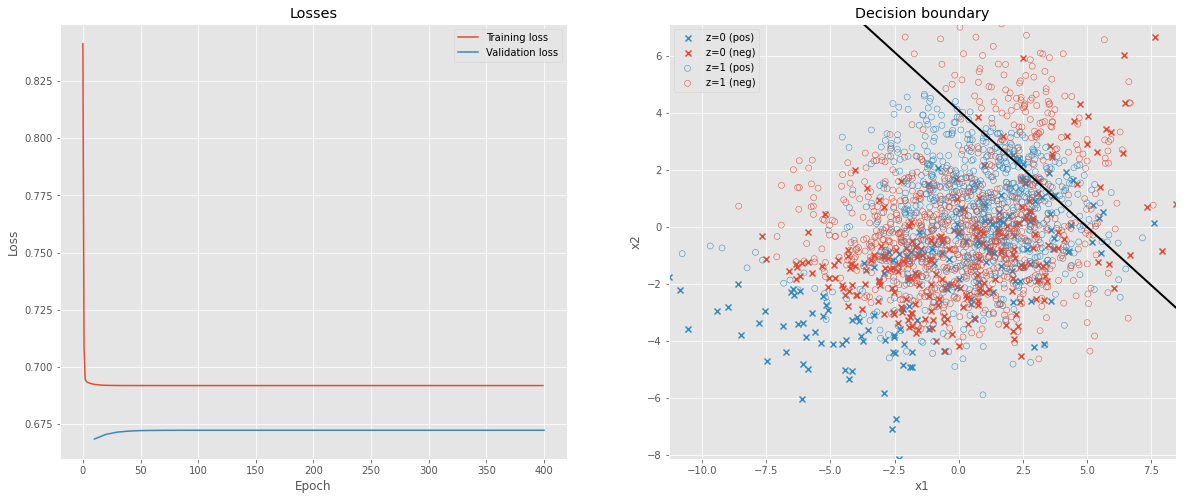

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(range(len(train_losses)), train_losses, label='Training loss')
axs[0].plot([i * val_epoch for i in range(1, len(val_losses) + 1)], val_losses, label='Validation loss')
axs[0].legend()
axs[0].set_title("Losses")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

plot_boundaries(lr_simple_model, xz_train, y_train, z_train, ax=axs[1])
axs[1].set_title("Decision boundary")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
plt.show()

One can see that the training loss remains stable after a few epochs, with the *vanilla* logistic regression not learning anything at that point. From the visualization on the right, it is clear that we are dealing with a complex classification problem in linear space, as the two classes are not linearly separable and form a single cluster. The noise injection on training labels makes the problem even harder than it is. The resulting linear classifier can therefore correctly classify only one of the two classes.

In [ ]:
test_last = test_model(model, xz_test, y_test, z_test)
print("At epoch {}:\ttest accuracy: {:.3f}, EO disparity: {:.3f}".format(
        epoch, test_last['Acc'], test_last['EqOdds_diff']))

test_best = test_model(lr_simple_model, xz_test, y_test, z_test)
print("At epoch {}:\ttest accuracy: {:.3f}, EO disparity: {:.3f}".format(
        best_epoch, test_best['Acc'], test_best['EqOdds_diff']))

At epoch 399:	 test accuracy: 0.652, EO disparity: 0.468
At epoch 9:	 test accuracy: 0.661, EO disparity: 0.268


The validation loss reaches its minimum shortly after the beginning of the training, at epoch 9. The resulting accuracy on the test data is better than the one achieved at the end of the training, as well as the EO disparity which is anyway not satisfactory. As predictable, as the authors of the paper did not use any validation technique, the results they report for *vanilla* logistic regression (accuracy 0.665, EO disparity 0.557) are comparable with the ones obtained by the model at the last epoch.

#### Fair and robust sampling

Let's now see how the performances vary when the sampler for fair and robust training is introduced. It does take into account the sensitive variable and the fact that some training labels are perturbated. The fraction of noisy labels is assumed to be known for every dataset.

As before, *hold-out* is used to select the best model over time, while training with the same parameters used by the authors.

In [ ]:
model = nn.Linear(n_features, 1)
if torch.cuda.is_available():
    model.cuda()
if seed is not None:
    torch.manual_seed(seed)
model.apply(weights_init_normal)

# optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999))
# fair robust sampler with respect to equalized odds
sampler = FairRobust(model, train_data.x, train_data.y, train_data.z, target_fairness='eqodds',
                     algorithm='lr', parameters=parameters, replacement=False, seed=seed)
train_loader = DataLoader(train_data, sampler=sampler, num_workers=0)

train_losses = []
val_losses = []
best_loss = float('inf')

for epoch in range(n_epochs):
    print(epoch, end="\r")

    model.train()

    tmp_loss = []

    # model is trained here
    for data, target, _ in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        loss = lr_epoch(model, data, target, optimizer)
        tmp_loss.append(loss)

    # store training loss
    train_loss = sum(tmp_loss) / len(tmp_loss)
    train_losses.append(train_loss)
    
    model.eval()
    
    with torch.no_grad():
        if (epoch + 1) % val_epoch == 0:
            # validation step
            label_predicted = model.forward(xz_val)
            val_loss = nn.BCELoss()((F.tanh(label_predicted.squeeze()) + 1) / 2, (y_val.squeeze() + 1) / 2)
            val_loss = val_loss.item()
            if val_loss < best_loss:
                # save model with lowest error on validation set
                best_loss = val_loss
                best_epoch = epoch
                fr_model = copy.deepcopy(model)
            # store validation loss
            val_losses.append(val_loss)
    
    # print intermediate results
    if (epoch + 1) % 50 == 0:
        print(f"epoch {epoch + 1}:\ttraining loss {train_loss:.3f}, validation loss {val_loss:.3f}")

epoch 50:	training loss 0.702, validation loss 0.639
epoch 100:	training loss 0.692, validation loss 0.672
epoch 150:	training loss 0.597, validation loss 0.621
epoch 200:	training loss 0.576, validation loss 0.632
epoch 250:	training loss 0.561, validation loss 0.640
epoch 300:	training loss 0.564, validation loss 0.636
epoch 350:	training loss 0.593, validation loss 0.624
epoch 400:	training loss 0.606, validation loss 0.614


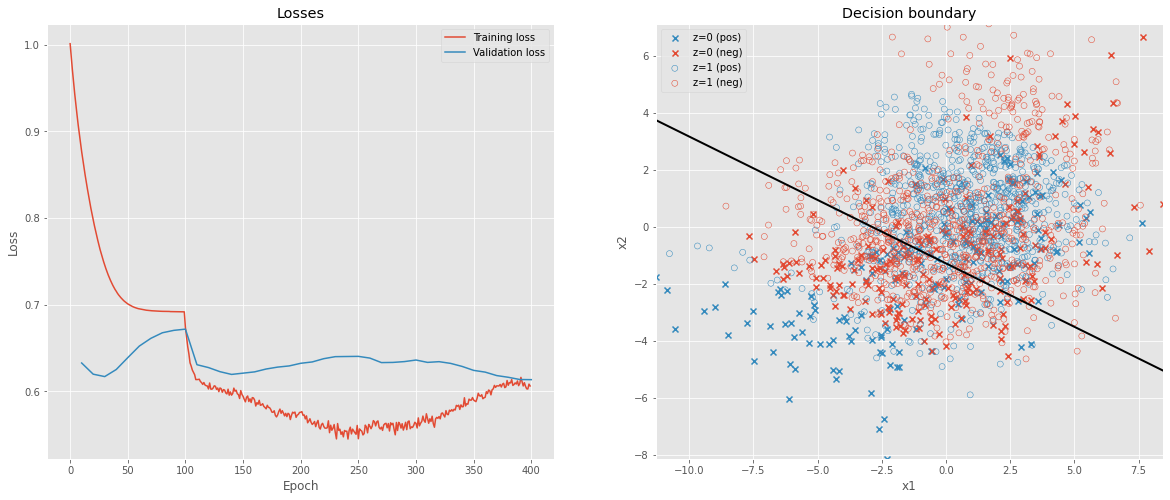

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(range(len(train_losses)), train_losses, label='Training loss')
axs[0].plot([i * val_epoch for i in range(1, len(val_losses) + 1)], val_losses, label='Validation loss')
axs[0].legend()
axs[0].set_title("Losses")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

plot_boundaries(fr_model, xz_train, y_train, z_train, ax=axs[1])
axs[1].set_title("Decision boundary")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
plt.show()

The resulting training curves are considerably different than before. Training loss decreases regularly until epoch 100 as the authors used warm-starting, training the first 100 epochs without fair or robust training in order to improve training stability. After this period, model is trained taking into account the sensitive variable and the noise in the data, which results in irregular training loss. Training and validation loss show that, taking into account noisy label, the model avoids overfitting and the lowest validation error is attained in the last epochs.

In [ ]:
test_last = test_model(model, xz_test, y_test, z_test)
print("At epoch {}:\ttest accuracy: {:.3f}, EO disparity: {:.3f}".format(
        epoch, test_last['Acc'], test_last['EqOdds_diff']))

test_best = test_model(fr_model, xz_test, y_test, z_test)
print("At epoch {}:\ttest accuracy: {:.3f}, EO disparity: {:.3f}".format(
        best_epoch, test_best['Acc'], test_best['EqOdds_diff']))

At epoch 399:	test accuracy: 0.724, EO disparity: 0.042
At epoch 399:	test accuracy: 0.724, EO disparity: 0.042


The results show that the proposed sampler has a positive impact on model performances. Resulting accuracy and EO disparity are better than the ones obtained with *vanilla* logistic regression and coherent with the results reported in the paper (accuracy 0.727, EO disparity 0.064).

#### Cross validation for fair and robust sampling

The authors state that the main hyperparameters of their method (the step size $\alpha$ for updating the sampling rate $\lambda$, and the learning rate) have been selected through cross validation. They are respectively selected from the sets {0.0001, 0.0005, 0.001} and {0.0001, 0.0005} and performances are optimized on the synthetic dataset setting them to 0.001 and 0.0005. It is therefore interesting to check how performances vary with other values for the two parameters.

K-fold cross validation can be used to select the best combination of hyperparameters. The training set is splitted into *k* parts and a different model for each possible combination is trained on *k*-1 of them and tested on the remaining one. For each combination of hyperparameters, *k* models are therefore trained and tested. The obtained results are then aggregated and the hyperparameters that lead to the highest average accuracy are selected.

In order to do so, data provided by the authors for training and validation can be merged and used for training, as they are drawn from the same data distribution and labels have the same noise ratio.

In [ ]:
xz = torch.cat((xz_train, xz_val), dim=0)
y = torch.cat((y_train, y_val), dim=0)
z = torch.cat((z_train, z_val), dim=0)

full_noisy_data = CustomDataset(xz, y, z)

Learning rate is here optimized in the set {0.00005, 0.0005, 0.005, 0.05}, while $\alpha$ is in {0.0001, 0.001, 0.01, 0.1}. K-fold is performed with *k*=5, training at each fold on 1760 examples and evaluating the performances on 440 examples. In addition, 20% of these 1760 examples are used for internal validation, in order to save the model at the training epoch that leads to the lowest validation error. To sum up, 1408, 352 and 440 examples are respectively used here for training, validation and testing.

In [ ]:
learning_rates = [0.00005, 0.0005, 0.005, 0.05]
alphas = [0.0001, 0.001, 0.01, 0.1]

lr_cv_results = {}

# generate splits for kfold
kf = KFold(n_splits=5, shuffle=True)
train_indexes = []
val_indexes = []
test_indexes = []
for train_index, test_index in kf.split(full_noisy_data):
    new_train_index, val_index = train_test_split(train_index, train_size=0.8)
    train_indexes.append(new_train_index)
    val_indexes.append(val_index)
    test_indexes.append(test_index)

for learning_rate in learning_rates:
    for alpha in alphas:
        print(f"LR: {learning_rate}, alpha: {alpha}")
        parameters = Namespace(warm_start=100, tau=1 - poi_ratio, alpha=alpha, batch_size=batch_size)

        test_acc = []
        test_diff = []
        for i, (train_index, val_index, test_index) in enumerate(zip(train_indexes, val_indexes, test_indexes)):
            print(f"\tFold {i + 1}:")
            train_data = full_noisy_data[train_index]
            val_data = full_noisy_data[val_index]
            test_data = full_noisy_data[test_index]

            model = nn.Linear(n_features, 1)
            if torch.cuda.is_available():
                model.cuda()
            if seed is not None:
                torch.manual_seed(seed)
            model.apply(weights_init_normal)

            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
            train_data = CustomDataset(train_data[0], train_data[1], train_data[2])
            sampler = FairRobust(model, train_data.x, train_data.y, train_data.z, target_fairness='eqodds',
                                 algorithm='lr', parameters=parameters, replacement=False, seed=seed)
            train_loader = DataLoader(train_data, sampler=sampler, num_workers=0)

            best_loss = float('inf')

            for epoch in range(n_epochs):
                print(epoch, end="\r")

                model.train()

                tmp_loss = []

                # model is trained here
                for data, target, _ in train_loader:
                    if torch.cuda.is_available():
                        data, target = data.cuda(), target.cuda()
                    loss = lr_epoch(model, data, target, optimizer)
                    tmp_loss.append(loss)
                train_loss = sum(tmp_loss) / len(tmp_loss)

                model.eval()
    
                with torch.no_grad():
                    if (epoch + 1) % val_epoch == 0:
                        # validation step
                        label_predicted = model.forward(val_data[0])
                        val_loss = nn.BCELoss()((F.tanh(label_predicted.squeeze()) + 1) / 2, (val_data[1].squeeze() + 1) / 2)
                        val_loss = val_loss.item()
                        if val_loss < best_loss:
                            # save model with lowest error on validation set
                            best_loss = val_loss
                            best_epoch = epoch
                            top_model = copy.deepcopy(model)
                
                # if (epoch + 1) % 50 == 0:
                #     print(f"\t\tepoch {epoch + 1}:\ttraining loss {train_loss:.3f}, validation loss {val_loss:.3f}")

            tmp_test = test_model(top_model, test_data[0], test_data[1], test_data[2])
            print("\t\tAt epoch {}:\ttest accuracy: {:.3f}, EO disparity: {:.3f}".format(
                      best_epoch, tmp_test['Acc'], tmp_test['EqOdds_diff']))
            test_acc.append(tmp_test['Acc'])
            test_diff.append(tmp_test['EqOdds_diff'])
        
        acc = sum(test_acc) / len(test_acc)
        diff = sum(test_diff) / len(test_diff)
        lr_cv_results[(learning_rate, alpha)] = (acc, diff)
        print(f"\n\tAverage accuracy: {acc:.3f}, average EO disparity: {diff:.3f}")
        print()

LR: 5e-05, alpha: 0.0001
	Fold 1:
		At epoch 149:	test accuracy: 0.584, EO disparity: 0.352
	Fold 2:
		At epoch 399:	test accuracy: 0.630, EO disparity: 0.272
	Fold 3:
		At epoch 109:	test accuracy: 0.586, EO disparity: 0.267
	Fold 4:
		At epoch 99:	test accuracy: 0.591, EO disparity: 0.245
	Fold 5:
		At epoch 399:	test accuracy: 0.575, EO disparity: 0.179

	Average accuracy: 0.593, average EO disparity: 0.263

LR: 5e-05, alpha: 0.001
	Fold 1:
		At epoch 129:	test accuracy: 0.582, EO disparity: 0.342
	Fold 2:
		At epoch 109:	test accuracy: 0.605, EO disparity: 0.345
	Fold 3:
		At epoch 109:	test accuracy: 0.586, EO disparity: 0.267
	Fold 4:
		At epoch 99:	test accuracy: 0.591, EO disparity: 0.245
	Fold 5:
		At epoch 139:	test accuracy: 0.568, EO disparity: 0.235

	Average accuracy: 0.586, average EO disparity: 0.287

LR: 5e-05, alpha: 0.01
	Fold 1:
		At epoch 109:	test accuracy: 0.575, EO disparity: 0.318
	Fold 2:
		At epoch 109:	test accuracy: 0.605, EO disparity: 0.345
	Fold 3:
		At 

Cross validation results are reported in the following table:

|Learning rate|$\alpha$|Accuracy|EO disparity|
|-|-|-|-|
|5e-05|0.0001|**0.593**|0.263|
|5e-05|0.001|0.586|0.286|
|5e-05|0.01|0.584|0.282|
|5e-05|0.1|0.582|0.285|
|0.0005|0.0001|0.583|**0.131**|
|0.0005|0.001|0.583|**0.131**|
|0.0005|0.01|0.583|**0.131**|
|0.0005|0.1|0.583|**0.131**|
|0.005|0.0001|0.581|0.240|
|0.005|0.001|0.581|0.240|
|0.005|0.01|0.581|0.240|
|0.005|0.1|0.581|0.240|
|0.05|0.0001|0.550|0.286|
|0.05|0.001|0.550|0.286|
|0.05|0.01|0.550|0.286|
|0.05|0.1|0.550|0.286|

It can be noticed that the best accuracy is obtained with learning rate 0.00005 and $\alpha$ 0.0001, while disparity is lower when learning rate is 0.0005. However, when learning rate is an order of magnitude higher than 0.00005, the hyperparameter $\alpha$ has no impact on the results. In addition, when the learning rate is high it can be noticed that the lowest validation loss is attained during the first epochs, meaning that the model is probably not able to converge.

#### Information criteria

Other popular methods of model selection follow a probabilistic approach. Such information criteria, such as AIC (Akaike information criterion) and BIC (bayesian information criterion), provide techniques for scoring and choosing among candidate models, taking into account both performance and complexity.

AIC is defined as:
$$\text{AIC} = -2\log(\hat{L}) + 2k$$
where $\hat{L}$ is the likelihood of the model on the training data and $k$ is the number of estimated parameters in the model.

Instead, BIC is defined as:
$$\text{BIC} = -2\log(\hat{L}) + k\log(n)$$
where $n$ is the number of training observations.

The log-likelihood for a probabilistic model for binary classification, such as logistic regression, is:
$$\sum_{i=1}^{n}y_i\log p(x_i) + (1-y_i)\log(1-p(x_i))$$
which can be used to compute AIC and BIC for the best model previously computed (learning rate 0.0005, $\alpha$ 0.001).

In [ ]:
train_output = fr_model(xz_train)
logl = nn.BCEWithLogitsLoss()(train_output.squeeze(), y_train).item()

The number of estimated parameters $k$ is equal to the number of features (3 in this case), plus the bias term.


In [ ]:
n_params = len(fr_model.weight.squeeze()) + len(fr_model.bias)
aic = -2 * logl + 2 * n_params
bic = -2 * logl + n_params * np.log(len(xz_train))

print(f"AIC = {aic:.3f}")
print(f"BIC = {bic:.3f}")

AIC = 6.529
BIC = 28.933


For the previously computed model, AIC is 6.529 and BIC 28.933. These values should be minimized in order to choose the best model. Let's therefore train a new model with the hyperparameters that achieved the highest accuracy with cross validation and compute AIC and BIC analogously.

In [ ]:
parameters = Namespace(warm_start=100, tau=1 - poi_ratio, alpha=0.01, batch_size=batch_size)
train_data = CustomDataset(xz_train, y_train, z_train)

model = nn.Linear(n_features, 1)
if torch.cuda.is_available():
    model.cuda()
if seed is not None:
    torch.manual_seed(seed)
model.apply(weights_init_normal)

# optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.999))
# fair robust sampler with respect to equalized odds
sampler = FairRobust(model, train_data.x, train_data.y, train_data.z, target_fairness='eqodds',
                     algorithm='lr', parameters=parameters, replacement=False, seed=seed)
train_loader = DataLoader(train_data, sampler=sampler, num_workers=0)

train_losses = []
val_losses = []
best_loss = float('inf')

for epoch in range(n_epochs):
    print(epoch, end="\r")

    model.train()

    tmp_loss = []

    # model is trained here
    for data, target, _ in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        loss = lr_epoch(model, data, target, optimizer)
        tmp_loss.append(loss)

    # store training loss
    train_loss = sum(tmp_loss) / len(tmp_loss)
    train_losses.append(train_loss)
    
    model.eval()
    
    with torch.no_grad():
        if (epoch + 1) % val_epoch == 0:
            # validation step
            label_predicted = model.forward(xz_val)
            val_loss = nn.BCELoss()((F.tanh(label_predicted.squeeze()) + 1) / 2, (y_val.squeeze() + 1) / 2)
            val_loss = val_loss.item()
            if val_loss < best_loss:
                # save model with lowest error on validation set
                best_loss = val_loss
                best_epoch = epoch
                best_model = copy.deepcopy(model)
            # store validation loss
            val_losses.append(val_loss)
    
    # print intermediate results
    if (epoch + 1) % 50 == 0:
        print(f"epoch {epoch + 1}:\ttraining loss {train_loss:.3f}, validation loss {val_loss:.3f}")

print()
train_output = best_model(xz_train)
logl = nn.BCEWithLogitsLoss()(train_output.squeeze(), y_train).item()
n_params = len(best_model.weight.squeeze()) + len(best_model.bias)
aic = -2 * logl + 2 * n_params
bic = -2 * logl + n_params * np.log(len(xz_train))

print(f"AIC = {aic:.3f}")
print(f"BIC = {bic:.3f}")

epoch 50:	training loss 0.938, validation loss 0.646
epoch 100:	training loss 0.882, validation loss 0.633
epoch 150:	training loss 0.455, validation loss 0.625
epoch 200:	training loss 0.424, validation loss 0.630
epoch 250:	training loss 0.411, validation loss 0.643
epoch 300:	training loss 0.395, validation loss 0.660
epoch 350:	training loss 0.377, validation loss 0.680
epoch 400:	training loss 0.371, validation loss 0.700

AIC = 6.585
BIC = 28.989


It is clear that the resulting AIC and BIC are comparable for the two models, which are therefore equivalent according to probabilistic model selection. To check for significance of the obtained results, let's compute AIC and BIC for one of the worst model, with learning rate 0.05.

In [ ]:
parameters = Namespace(warm_start=100, tau=1 - poi_ratio, alpha=0.0001, batch_size=batch_size)
train_data = CustomDataset(xz_train, y_train, z_train)

model = nn.Linear(n_features, 1)
if torch.cuda.is_available():
    model.cuda()
if seed is not None:
    torch.manual_seed(seed)
model.apply(weights_init_normal)

# optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999))
# fair robust sampler with respect to equalized odds
sampler = FairRobust(model, train_data.x, train_data.y, train_data.z, target_fairness='eqodds',
                     algorithm='lr', parameters=parameters, replacement=False, seed=seed)
train_loader = DataLoader(train_data, sampler=sampler, num_workers=0)

train_losses = []
val_losses = []
best_loss = float('inf')

for epoch in range(n_epochs):
    print(epoch, end="\r")

    model.train()

    tmp_loss = []

    # model is trained here
    for data, target, _ in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        loss = lr_epoch(model, data, target, optimizer)
        tmp_loss.append(loss)

    # store training loss
    train_loss = sum(tmp_loss) / len(tmp_loss)
    train_losses.append(train_loss)
    
    model.eval()
    
    with torch.no_grad():
        if (epoch + 1) % val_epoch == 0:
            # validation step
            label_predicted = model.forward(xz_val)
            val_loss = nn.BCELoss()((F.tanh(label_predicted.squeeze()) + 1) / 2, (y_val.squeeze() + 1) / 2)
            val_loss = val_loss.item()
            if val_loss < best_loss:
                # save model with lowest error on validation set
                best_loss = val_loss
                best_epoch = epoch
                bad_model = copy.deepcopy(model)
            # store validation loss
            val_losses.append(val_loss)
    
    # print intermediate results
    if (epoch + 1) % 50 == 0:
        print(f"epoch {epoch + 1}:\ttraining loss {train_loss:.3f}, validation loss {val_loss:.3f}")

print()
train_output = bad_model(xz_train)
logl = nn.BCEWithLogitsLoss()(train_output.squeeze(), y_train).item()
n_params = len(bad_model.weight.squeeze()) + len(bad_model.bias)
aic = -2 * logl + 2 * n_params
bic = -2 * logl + n_params * np.log(len(xz_train))

print(f"AIC = {aic:.3f}")
print(f"BIC = {bic:.3f}")

epoch 50:	training loss 0.700, validation loss 0.672
epoch 100:	training loss 0.695, validation loss 0.773
epoch 150:	training loss 0.597, validation loss 0.619
epoch 200:	training loss 0.600, validation loss 0.644
epoch 250:	training loss 0.600, validation loss 0.615
epoch 300:	training loss 0.595, validation loss 0.622
epoch 350:	training loss 0.594, validation loss 0.622
epoch 400:	training loss 0.596, validation loss 0.601

AIC = 6.645
BIC = 29.048


### Support Vector Machines

Support Vector Machines (SVM) are another class of powerful linear classifiers. Differently from logistic regression, the goal of SVM is to correctly classify examples with the largest possible margin, i.e. distance between training examples and decision boundary. The method has not been tested by the paper's authors and no benchmark is therefore available.

The implementation in PyTorch available in this GitHub [repository](https://github.com/kazuto1011/svm-pytorch) is followed here and the code for the sampler is modified accordingly. SVM can be extended with kernel methods in order to find separating hyperplanes in higher dimensions, but it is not straightforward to implement in PyTorch and that goes beyond the objective of this report.

Let's train a linear SVM on the synthetic dataset without using the fair and robust sampler, as previously done for logistic regression. The regularization parameter *C* is here arbitrarily set to 0.01.

In [ ]:
c = 0.01
train_data = CustomDataset(xz_train, y_train, z_train)

# svm is composed of a single linear layer
model = nn.Linear(n_features, 1)
if torch.cuda.is_available():
    model.cuda()
if seed is not None:
    torch.manual_seed(seed)
model.apply(weights_init_normal)

# optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999))
train_loader = DataLoader(train_data, num_workers=0)

train_losses = []
val_losses = []
best_loss = float('inf')

for epoch in range(150):
    print(epoch, end="\r")

    model.train()

    tmp_loss = []

    # model is trained here
    for data, target, _ in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        loss = svm_epoch(model, c, data, target, optimizer)
        tmp_loss.append(loss)

    # store training loss
    train_loss = sum(tmp_loss) / len(tmp_loss)
    train_losses.append(train_loss)
    
    model.eval()
    
    with torch.no_grad():
        if (epoch + 1) % val_epoch == 0:
            # validation step
            label_predicted = model.forward(xz_val)
            weight = model.weight.squeeze()
            val_loss = torch.mean(torch.clamp(1 - y_val.squeeze() * label_predicted.squeeze(), min=0))
            val_loss += c * (weight.t() @ weight) / 2.0
            val_loss = val_loss.item()
            if val_loss < best_loss:
                # save model with lowest error on validation set
                best_loss = val_loss
                best_epoch = epoch
                svm_simple_model = copy.deepcopy(model)
            # store validation loss
            val_losses.append(val_loss)
    
    # print intermediate results
    if (epoch + 1) % 50 == 0:
        print(f"epoch {epoch + 1}:\ttraining loss {train_loss:.3f}, validation loss {val_loss:.3f}")

epoch 50:	training loss 0.970, validation loss 0.764
epoch 100:	training loss 0.970, validation loss 0.768
epoch 150:	training loss 0.970, validation loss 0.770


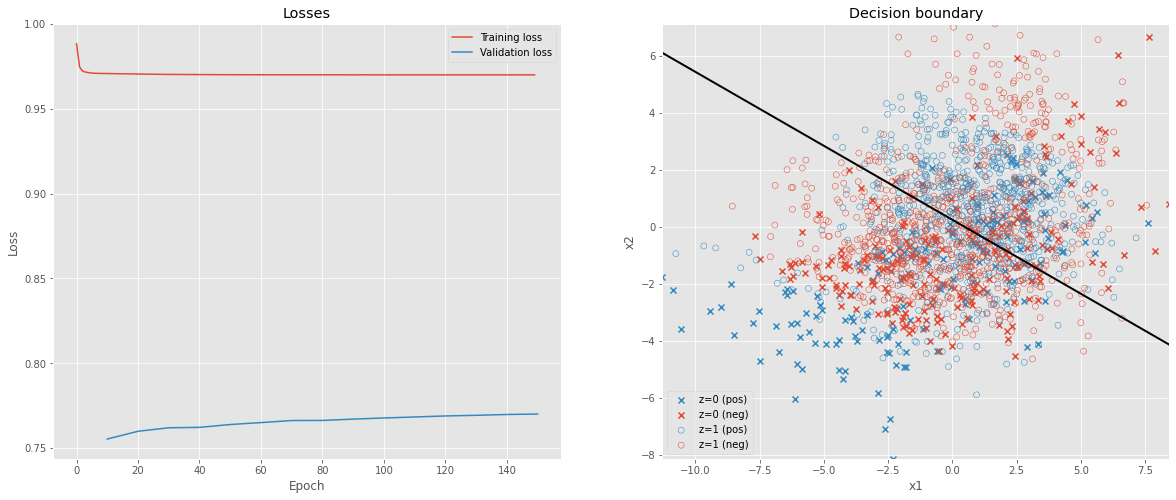

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(range(len(train_losses)), train_losses, label='Training loss')
axs[0].plot([i * val_epoch for i in range(1, len(val_losses) + 1)], val_losses, label='Validation loss')
axs[0].legend()
axs[0].set_title("Losses")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

plot_boundaries(svm_simple_model, xz_train, y_train, z_train, ax=axs[1])
axs[1].set_title("Decision boundary")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
plt.show()

In [ ]:
test_last = test_model(model, xz_test, y_test, z_test)
print("At epoch {}:\ttest accuracy: {:.3f}, EO disparity: {:.3f}".format(
        epoch, test_last['Acc'], test_last['EqOdds_diff']))

test_best = test_model(svm_simple_model, xz_test, y_test, z_test)
print("At epoch {}:\ttest accuracy: {:.3f}, EO disparity: {:.3f}".format(
        best_epoch, test_best['Acc'], test_best['EqOdds_diff']))

At epoch 149:	test accuracy: 0.727, EO disparity: 0.246
At epoch 9:	test accuracy: 0.731, EO disparity: 0.187


#### Cross validation

As before, K-fold cross validation can be performed on SVM. For time constraints, only *C* is optimized while learning rate and $\alpha$ are fixed. The K-fold parameters are kept as before.

In [ ]:
cs = [0.001, 0.01, 0.1, 1]

svm_cv_results = {}
alpha = 0.001
parameters = Namespace(warm_start=100, tau=1 - poi_ratio, alpha=alpha, batch_size=batch_size)

for c in cs:
    print(f"C: {c}")

    test_acc = []
    test_diff = []
    for i, (train_index, val_index, test_index) in enumerate(zip(train_indexes, val_indexes, test_indexes)):
        print(f"\tFold {i + 1}:")
        train_data = full_noisy_data[train_index]
        val_data = full_noisy_data[val_index]
        test_data = full_noisy_data[test_index]

        model = nn.Linear(n_features, 1)
        if torch.cuda.is_available():
            model.cuda()
        if seed is not None:
            torch.manual_seed(seed)
        model.apply(weights_init_normal)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999))
        train_data = CustomDataset(train_data[0], train_data[1], train_data[2])
        sampler = FairRobust(model, train_data.x, train_data.y, train_data.z, target_fairness='eqodds',
                            algorithm='lr', parameters=parameters, replacement=False, seed=seed)
        train_loader = DataLoader(train_data, sampler=sampler, num_workers=0)

        best_loss = float('inf')

        for epoch in range(n_epochs):
            print(epoch, end="\r")

            model.train()

            tmp_loss = []

            # model is trained here
            for data, target, _ in train_loader:
                if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()
                loss = svm_epoch(model, c, data, target, optimizer)
                tmp_loss.append(loss)
            train_loss = sum(tmp_loss) / len(tmp_loss)

            model.eval()

            with torch.no_grad():
                if (epoch + 1) % val_epoch == 0:
                    # validation step
                    label_predicted = model.forward(val_data[0])
                    val_loss = nn.BCELoss()((F.tanh(label_predicted.squeeze()) + 1) / 2, (val_data[1].squeeze() + 1) / 2)
                    val_loss = val_loss.item()
                    if val_loss < best_loss:
                        # save model with lowest error on validation set
                        best_loss = val_loss
                        best_epoch = epoch
                        top_model = copy.deepcopy(model)
            
            # if (epoch + 1) % 50 == 0:
            #     print(f"\t\tepoch {epoch + 1}:\ttraining loss {train_loss:.3f}, validation loss {val_loss:.3f}")

        tmp_test = test_model(top_model, test_data[0], test_data[1], test_data[2])
        print("\t\tAt epoch {}:\ttest accuracy: {:.3f}, EO disparity: {:.3f}".format(
                  best_epoch, tmp_test['Acc'], tmp_test['EqOdds_diff']))
        test_acc.append(tmp_test['Acc'])
        test_diff.append(tmp_test['EqOdds_diff'])
    
    acc = sum(test_acc) / len(test_acc)
    diff = sum(test_diff) / len(test_diff)
    svm_cv_results[(learning_rate, alpha)] = (acc, diff)
    print(f"\n\tAverage accuracy: {acc:.3f}, average EO disparity: {diff:.3f}")
    print()

C: 0.001
	Fold 1:
		At epoch 99:	test accuracy: 0.593, EO disparity: 0.354
	Fold 2:
		At epoch 99:	test accuracy: 0.609, EO disparity: 0.158
	Fold 3:
		At epoch 89:	test accuracy: 0.634, EO disparity: 0.307
	Fold 4:
		At epoch 89:	test accuracy: 0.614, EO disparity: 0.235
	Fold 5:
		At epoch 89:	test accuracy: 0.582, EO disparity: 0.179

	Average accuracy: 0.606, average EO disparity: 0.247

C: 0.01
	Fold 1:
		At epoch 99:	test accuracy: 0.593, EO disparity: 0.354
	Fold 2:
		At epoch 99:	test accuracy: 0.609, EO disparity: 0.158
	Fold 3:
		At epoch 89:	test accuracy: 0.634, EO disparity: 0.307
	Fold 4:
		At epoch 89:	test accuracy: 0.614, EO disparity: 0.235
	Fold 5:
		At epoch 89:	test accuracy: 0.580, EO disparity: 0.179

	Average accuracy: 0.606, average EO disparity: 0.247

C: 0.1
	Fold 1:
		At epoch 99:	test accuracy: 0.589, EO disparity: 0.358
	Fold 2:
		At epoch 99:	test accuracy: 0.607, EO disparity: 0.176
	Fold 3:
		At epoch 99:	test accuracy: 0.630, EO disparity: 0.307
	Fold 

Cross validation results are reported in the following table:

|C|Accuracy|EO disparity|
|-|-|-|
|0.001|**0.606**|0.247|
|0.01|**0.606**|0.247|
|0.1|0.603|0.261|
|1|0.581|**0.197**|

Resulting average accuracies are slightly better than the ones previously obtained with logistic regression, while EO disparity is generally higher.

Differently from logistic regression, SVM do not compute prediction probabilities, so it is not possible to evaluate them through information criteria.

## Real datasets

Up to this point, experiments have been performed on the synthetic dataset provided by the authors. However, several datasets exists in the literature for fair machine classification, as listed in an accurate [survey](https://arxiv.org/abs/2110.00530v2) by Le Qui *et al.*.

For fair and robust sampling, paper's authors tested the method on two real dataset:

- [ProPublica COMPAS](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis): a dataset for the classification task of predicting if an individual is rearrested within two years after its first arrest. It contains 7214 examples with 52 features. The sensitive attributes are race and gender of the convicted.
- [AdultCensus](https://archive.ics.uci.edu/ml/datasets/adult): a dataset for the classification task of predicting whether the annual income of a person exceeds 50K dollars based on demographic characteristics. It is a big dataset containing 48842 examples with 15 features. The sensitive attributes are gender, race and age.

For both datasets, authors considered gender as sensitive attribute.

For the next experiments, the proposed method is tested on a real dataset.

### Credit card clients dataset

The [credit card clients dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) is a dataset consisting of 30000 examples with 24 attributes. The objective is to predict whether a customer will face a default in the next month or not. The gender can be considered as sensitive attribute. The vast majority of the observations is related to females, ratio 60%:40%.

In [ ]:
def zero_to_minus_one(x):
    if x == 0:
        return -1
    return x

credit_df = pd.read_excel("datasets/credit.xls", skiprows=1).drop(columns=['ID'])
credit_df.rename(columns={"default payment next month": "next"}, inplace=True)
credit_df['SEX'] = credit_df['SEX'].apply(lambda x: x - 1)
credit_df['next'] = credit_df['next'].apply(zero_to_minus_one)
credit_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,next
0,20000,1,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,1,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,1,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,-1
3,50000,1,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,-1
4,50000,0,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,-1


Data have to be organized as expected by the method. It can also be noticed that some features have higher values than the others, so data are scaled to have mean 0 and variance 1.

In [ ]:
z_credit = np.array(credit_df['SEX'])
y_credit = np.array(credit_df['next'])
x_credit = np.array(credit_df.drop(columns=['SEX', 'next']))

x_credit = StandardScaler().fit_transform(x_credit)

xz_credit = np.concatenate((x_credit, z_credit[:, np.newaxis]), axis=1)

In [ ]:
n_features = xz_credit.shape[-1]    # number of input features, including sensitive variable
poi_ratio = 0.1   # percentage of perturbated labels
n_epochs = 1000    # number of training epochs
alpha = 0.001     # step size for updating sampler's lambda
batch_size = 2000  # batch size for data loading
val_epoch = 10    # number of epochs between validation steps

The dataset is split in training, validation and test data, in proportion 6:2:2. As before, noise is injected with ratio 0.1. Due to the big size of the dataset and to the computational limitations, only *hold-out* is tested with the dataset, as cross validation would require too many resources. The objective here is to assess the effectiveness of the fair and robust sampling method on a real dataset, different from the ones tested by the authors.

In [ ]:
xz_ctrain, xz_ctest, y_ctrain, y_ctest, z_ctrain, z_ctest = train_test_split(xz_credit, y_credit, z_credit, train_size=0.8)
y_ctrain = corrupt_labels(y_ctrain, poi_ratio=poi_ratio)
xz_ctrain, xz_cval, y_ctrain, y_cval, z_ctrain, z_cval = train_test_split(xz_ctrain, y_ctrain, z_ctrain, train_size=0.75)

xz_ctrain = torch.FloatTensor(xz_ctrain)
y_ctrain = torch.FloatTensor(y_ctrain)
z_ctrain = torch.FloatTensor(z_ctrain)

xz_cval = torch.FloatTensor(xz_cval)
y_cval = torch.FloatTensor(y_cval)
z_cval = torch.FloatTensor(z_cval)

xz_ctest = torch.FloatTensor(xz_ctest)
y_ctest = torch.FloatTensor(y_ctest)
z_ctest = torch.FloatTensor(z_ctest)

if torch.cuda.is_available():
    xz_ctrain = xz_ctrain.cuda()
    y_ctrain = y_ctrain.cuda()
    z_ctrain = z_ctrain.cuda()
    
    xz_cval = xz_cval.cuda()
    y_cval = y_cval.cuda()
    z_cval = z_cval.cuda()

    xz_ctest = xz_ctest.cuda()
    y_ctest = y_ctest.cuda()
    z_ctest = z_ctest.cuda()

In [ ]:
print("---------- Number of Data ----------" )
print(
    "Train data : %d, Val data: %d, Test data : %d "
    % (len(y_ctrain), len(y_cval), len(y_ctest))
)       
print("------------------------------------")

---------- Number of Data ----------
Train data : 18000, Val data: 6000, Test data : 6000 
------------------------------------


In [ ]:
parameters = Namespace(warm_start=100, tau=1 - poi_ratio, alpha=alpha, batch_size=batch_size)
train_cdata = CustomDataset(xz_ctrain, y_ctrain, z_ctrain)

In [ ]:
model = nn.Linear(n_features, 1)
if torch.cuda.is_available():
    model.cuda()
if seed is not None:
    torch.manual_seed(seed)
model.apply(weights_init_normal)

# optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999))
# fair robust sampler with respect to equalized odds
sampler = FairRobust(model, train_cdata.x, train_cdata.y, train_cdata.z, target_fairness='eqodds',
                     algorithm='lr', parameters=parameters, replacement=False, seed=seed)
train_loader = DataLoader(train_cdata, sampler=sampler, num_workers=0)

train_losses = []
val_losses = []
best_loss = float('inf')

for epoch in range(n_epochs):
    print(epoch, end="\r")

    model.train()

    tmp_loss = []

    # model is trained here
    for data, target, _ in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        loss = lr_epoch(model, data, target, optimizer)
        tmp_loss.append(loss)

    # store training loss
    train_loss = sum(tmp_loss) / len(tmp_loss)
    train_losses.append(train_loss)
    
    model.eval()
    
    with torch.no_grad():
        if (epoch + 1) % val_epoch == 0:
            # validation step
            label_predicted = model.forward(xz_cval)
            val_loss = nn.BCELoss()((F.tanh(label_predicted.squeeze()) + 1) / 2, (y_cval.squeeze() + 1) / 2)
            val_loss = val_loss.item()
            if val_loss < best_loss:
                # save model with lowest error on validation set
                best_loss = val_loss
                best_epoch = epoch
                fr_credit_model = copy.deepcopy(model)
            # store validation loss
            val_losses.append(val_loss)
    
    # print intermediate results
    if (epoch + 1) % 50 == 0:
        print(f"epoch {epoch + 1}:\ttraining loss {train_loss:.3f}, validation loss {val_loss:.3f}")

epoch 50:	training loss 0.987, validation loss 0.954
epoch 100:	training loss 0.824, validation loss 0.803
epoch 150:	training loss 0.607, validation loss 0.769
epoch 200:	training loss 0.572, validation loss 0.739
epoch 250:	training loss 0.535, validation loss 0.711
epoch 300:	training loss 0.496, validation loss 0.688
epoch 350:	training loss 0.466, validation loss 0.671
epoch 400:	training loss 0.399, validation loss 0.661
epoch 450:	training loss 0.336, validation loss 0.661
epoch 500:	training loss 0.280, validation loss 0.668
epoch 550:	training loss 0.226, validation loss 0.680
epoch 600:	training loss 0.187, validation loss 0.697
epoch 650:	training loss 0.150, validation loss 0.717
epoch 700:	training loss 0.122, validation loss 0.735
epoch 750:	training loss 0.103, validation loss 0.756
epoch 800:	training loss 0.093, validation loss 0.778
epoch 850:	training loss 0.083, validation loss 0.801
epoch 900:	training loss 0.075, validation loss 0.824
epoch 950:	training loss 0.06

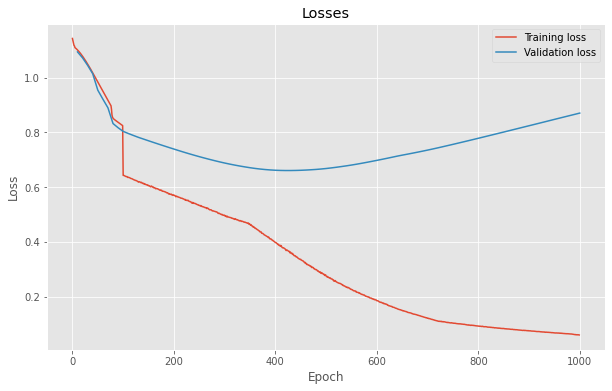

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training loss')
plt.plot([i * val_epoch for i in range(1, len(val_losses) + 1)], val_losses, label='Validation loss')
plt.legend()
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
test_best = test_model(fr_credit_model, xz_ctest, y_ctest, z_ctest)
print("At epoch {}:\ttest accuracy: {:.3f}, EO disparity: {:.3f}".format(
        best_epoch, test_best['Acc'], test_best['EqOdds_diff']))

At epoch 419:	test accuracy: 0.747, EO disparity: 0.075


Differently from before with synthetic data, it can be seen that in this case the model clearly overfits the training data. Validation error reaches a minimum around epoch 400, but then increases while training error keeps decreasing. For the same dataset, [Le Quy *et al.*](https://arxiv.org/abs/2110.00530v2) report accuracy 0.782 and EO disparity 0.0, not far from the results obtained here. They could be improved optimizing the method hyperparameters, for example via cross validation.

As logistic regression is used, it is also possible to compute AIC and BIC for the trained model.

In [ ]:
train_output = fr_credit_model(xz_ctrain)
logl = nn.BCEWithLogitsLoss()(train_output.squeeze(), y_ctrain).item()
n_params = len(fr_credit_model.weight.squeeze()) + len(fr_credit_model.bias)
aic = -2 * logl + 2 * n_params
bic = -2 * logl + n_params * np.log(len(xz_train))

print(f"AIC = {aic:.3f}")
print(f"BIC = {bic:.3f}")

AIC = 47.527
BIC = 181.949


The high resulting values depend for sure on the higher number of explanatory variables with respect to the synthetic dataset (24 versus 3), which lead to more complex models.

## Conclusion

Fairness and robustness are becoming more and more important in modern machine learning applications, and the need to take sensitive attributes into account will increase in the future. Methods like the one faced here help to improve accuracy and fairness at the same time in the presence of noisy data, which would have seemed impossible a few years ago. Even though obtained results are satisfactory, the conducted experiments show the need of always carefully assess the performances and select the best machine learning model, depending on data and applications.